### Table of Contents

* [Data Cleaning](#Data-Cleaning)
* [Data Exploration](#Data-Exploration)
* [Retention Rate Over Time](#Retention-Rate-Over-Time)
* [Duration Analysis](#Duration-Analysis)

In [1]:
#Import libraries
import pandas as pd
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
#Read in the data
df = pd.read_csv('data/2021_12_07.csv', parse_dates = ['start_date', 'end_date'], dtype={'work_postal':'str'})

# Data Cleaning

In [2]:
#Replace under_29 by .under_29 to make it easier when sorting
df['age_group'] = df['age_group'].replace(to_replace='under_29', value='.under_29')

#Replace under_1 by .under_1 to make it easier when sorting
df['tenure_group_by_department'] = df['tenure_group_by_department'].replace(to_replace='under_1', value='.under_1')

#Condense the records into one row and return the dataframe
#  ids: list of employee ids to condense
def construct_df(ids):
    #Define Voluntary Termination Reasons
    vol_ter = ['Resignation', 'Employee Never reported toWork', 'Job Abandonment']
    #Temporary end date
    temp_end_date = pd.to_datetime('2021-12-07')
    
    duration = []                #total duration of employment in days
    tenure_group = []            #duration in categories
    division = []                #last division employed at
    comprate = []                #highest comprate during employment
    num_of_pay_raise = []        #number of pay raises the employee got
    sex = []                     #gender
    ethnicity = []               #ethnicity
    mar_status = []              #marital status
    highest_educ_lvl = []        #highest education level
    end_age_group = []           #end age group
    start_age_group = []         #start age group
    classification = []          #last classification
    department_change = []       #number of department changes
    division_change = []         #number of division changes
    pay_increase_ot = []         #(max comprate - min comprate) / duration
    last_jobtitle_duration = []  #duration of last held jobtitle in days
    event = []                   #Unknown, Retirement, Termination
    
    #Condense each employee
    for ID in ids:
        #Get all records of the employee
        employee = df[df['emplid_sec'] == ID].copy()

        ##### DURATION #####
        #number of days worked as of 2021-12-07 (Includes end date)
        duration.append(int(sum(employee['duration'].tolist(), employee.shape[0])))
        
        ##### DURATION GROUP #####
        #Tenure group by department
        tenure_group.append(sorted(employee['tenure_group_by_department'].unique().tolist())[-1])

        ##### DIVISION #####
        #Get the last division they were in
        employee.sort_values(by=['end_date'], inplace=True)
        division.append(employee.iloc[-1]['division'])

        ##### COMP RATE #####
        #Get their highest comprate
        comprate.append(max(employee['comprate'].tolist()))

        ##### NUMBER OF PAY RAISES #####
        #Get the number of pay raises the employee had during the employement
        num_of_pay_raise.append(employee['comprate'].unique().size)
        
        ##### SEX #####
        employee.sort_values(by=['end_date'], inplace=True)
        sex.append(employee.iloc[-1]['sex'])
        
        ##### ETHNITICY #####
        employee.sort_values(by=['end_date'], inplace=True)
        ethnicity.append(employee.iloc[-1]['ethnicity'])
        
        ##### MARITAL STATUS #####
        #Get the last marital status
        employee.sort_values(by=['end_date'], inplace=True)
        mar_status.append(employee.iloc[-1]['mar_status'])

        ##### EDUCATION LEVEL #####
        #Get the highest education level
        highest_educ_lvl.append(sorted(employee['highest_educ_lvl'].tolist())[-1])

        ##### END AGE GROUP #####
        #Get the age group they were before they left
        end_age_group.append(sorted(employee['age_group'].unique().tolist())[-1])
        
        ##### START AGE GROUP #####
        #Get the age group when they first started
        start_age_group.append(sorted(employee['age_group'].unique().tolist())[0])
        
        ##### CLASSIFICATION #####
        #Get the last classification
        employee.sort_values(by=['end_date'], inplace=True)
        classification.append(employee.iloc[-1]['classification'])
        
        ##### DEPARTMENT CHANGE #####
        #Get the number of department changes during the employement
        department_change.append(max(0, employee['deptartment_joiners'].sum() - 1))
        
        ##### DIVISION CHANGE #####
        #Get the number of division changes during the employement
        division_change.append(max(0, employee['division_joiners'].sum() - 1))

        ##### COMPRATE INCREASE OVER TIME #####
        #(max - min) / duration
        max_rate = max(employee['comprate'].tolist())
        min_rate = min(employee['comprate'].tolist())
        pay_increase_ot.append((max_rate - min_rate) / duration[-1])

        ##### DURATION OF CURRENT POSITION #####
        #Get the duration in days of the last jobtitle they held or currently holding
        employee.sort_values(by=['end_date'], inplace=True)
        last_jobtitle = employee.iloc[-1]['jobtitle']
        last_jobtitle_duration.append(employee.iloc[-1]['duration'] + 1)
        for i in reversed(range(len(employee) - 1)):
            if(employee.iloc[i]['jobtitle'] == last_jobtitle):
                last_jobtitle_duration[-1] += employee.iloc[i]['duration'] + 1
            else:
                break

        ##### EVENT #####
        employee.sort_values(by=['end_date'], inplace=True)
        temp_employee = employee[employee['event'] != 'unknown'].copy()
        if(temp_employee.shape[0] == 0):
            event.append('unknown')
        elif(temp_employee.iloc[-1]['event'] == 'Termination'):
            if(temp_employee.iloc[-1]['event_reason'] in vol_ter):
                event.append('V Termination')
            else:
                event.append('IV Termination')
        else:
            event.append('Retirement')


    #Construct Dataframe
    return pd.DataFrame({'duration': duration,
                         'tenure_group': tenure_group,
                         'division': division,
                         'comprate': comprate,
                         'num_of_pay_raise': num_of_pay_raise,
                         'sex': sex,
                         'ethnicity': ethnicity,
                         'mar_status': mar_status,
                         'highest_educ_lvl': highest_educ_lvl,
                         'end_age_group': end_age_group,
                         'start_age_group': start_age_group,
                         'classification': classification,
                         'department_change': department_change,
                         'division_change': division_change,
                         'pay_increase_ot': pay_increase_ot,
                         'last_jobtitle_duration': last_jobtitle_duration,
                         'emplid_sec': ids,
                         'event': event})

In [3]:
#Current employees (currently working)
temp_df = df[df['end_date'].isna()]
curr_empl_ids = temp_df['emplid_sec'].unique()

#Past employees (currently not working)
all_empl_ids = df['emplid_sec'].unique()
past_empl_ids = [i for i in all_empl_ids if i not in curr_empl_ids]

#Past employees
past_empl_df = construct_df(past_empl_ids)

#Current employees
curr_empl_df = construct_df(curr_empl_ids)

#All employees
all_empl_df = pd.concat([past_empl_df, curr_empl_df])

In [4]:
#Export the new datasets
past_empl_df.to_csv('data/past.csv', index=False)
curr_empl_df.to_csv('data/current.csv', index=False)
all_empl_df.to_csv('data/all.csv', index=False)

In [5]:
#Read in cleaned data
past_empl_df = pd.read_csv('data/past.csv')
curr_empl_df = pd.read_csv('data/current.csv')
all_empl_df = pd.read_csv('data/all.csv')

# Data Exploration

In [6]:
all_empl_df.shape

(11859, 18)

In [7]:
all_empl_df.isna().sum()

duration                     0
tenure_group                 0
division                     0
comprate                     0
num_of_pay_raise             0
sex                       1485
ethnicity                  577
mar_status                1485
highest_educ_lvl          1485
end_age_group             1486
start_age_group           1486
classification               0
department_change            0
division_change              0
pay_increase_ot              0
last_jobtitle_duration       0
emplid_sec                   0
event                        0
dtype: int64

There are some missing values for columns `sex`, `ethnicity`, `mar_status`, `highest_educ_lvl`, `end_age_group`, and `start_age_group`.

In [8]:
all_empl_df.describe()

,duration,comprate,num_of_pay_raise,department_change,division_change,pay_increase_ot,last_jobtitle_duration
count,11859.000000,11859.000000,11859.000000,11859.000000,11859.000000,11859.000000,11859.000000
mean,2688.048739,25.103131,5.145206,0.512101,0.770807,0.003742,1390.214624
std,2360.091080,10.306857,3.680048,0.730340,1.042973,0.006118,1662.092807
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,594.000000,17.185974,2.000000,0.000000,0.000000,0.001448,244.365498
50%,2111.000000,23.736800,4.000000,0.000000,0.000000,0.002895,693.000000
75%,4228.000000,30.182622,8.000000,1.000000,1.000000,0.004329,2008.365498
max,8570.000000,141.166400,25.000000,6.000000,10.000000,0.220725,8567.365498


In [9]:
all_empl_df['tenure_group'].value_counts(normalize=True, dropna=False)

over_5      0.510161
.under_1    0.197824
1_to_2      0.182562
3_to_4      0.109453
Name: tenure_group, dtype: float64

The majority of the employees in the dataset were employed for more than 5 years.

In [10]:
all_empl_df['division'].value_counts(normalize=True, dropna=False)

Self Sufficiency           0.408129
Children Services          0.262501
Other                      0.125980
Administrative Services    0.098153
Adult Services             0.085420
Finance and Forecasting    0.010119
Public Authority           0.009697
Name: division, dtype: float64

Most of the employees in the dataset are in the division `Self Sufficiency` and `Children Services`.

In [11]:
all_empl_df['sex'].value_counts(normalize=True, dropna=False)

F      0.712708
M      0.161987
NaN    0.125221
U      0.000084
Name: sex, dtype: float64

The majority of the employees are female.

In [12]:
all_empl_df['ethnicity'].value_counts(normalize=True, dropna=False)

HISPA    0.375833
WHITE    0.314866
BLACK    0.149507
NSPEC    0.054220
NaN      0.048655
ASIAN    0.035416
2PLUS    0.007926
PACIF    0.007505
AMIND    0.006071
Name: ethnicity, dtype: float64

Most of the employees in the dataset are `Hispanic`, `White`, and `Black`.

In [13]:
all_empl_df['mar_status'].value_counts(normalize=True, dropna=False)

U      0.604604
S      0.256851
NaN    0.125221
M      0.011299
D      0.001855
H      0.000084
E      0.000084
Name: mar_status, dtype: float64

Looking at marital status, **60%** of data are `unspecified`, **12%** of the data are `missing`, and **26%** of employees indicated `Single`.

In [14]:
all_empl_df['highest_educ_lvl'].value_counts(normalize=True, dropna=False)

A      0.740113
NaN    0.125221
G      0.040813
I      0.032886
D      0.023442
C      0.018130
F      0.009950
H      0.004301
E      0.002867
K      0.000843
J      0.000675
B      0.000590
L      0.000169
Name: highest_educ_lvl, dtype: float64

Looking at education, **74%** of data are `unspecified`, and **12%** of the data are `missing`.

In [15]:
all_empl_df['end_age_group'].value_counts(normalize=True, dropna=False)

.under_29    0.141327
30_to_34     0.141327
35_to_39     0.130281
NaN          0.125306
40_to_44     0.108862
over_60      0.094865
50_to_54     0.092335
45_to_49     0.089384
55_to_59     0.076313
Name: end_age_group, dtype: float64

There's a somewhat even distribution for ending age group.

In [16]:
all_empl_df['start_age_group'].value_counts(normalize=True, dropna=False)

.under_29    0.310987
30_to_34     0.152121
NaN          0.125306
35_to_39     0.117801
40_to_44     0.091407
45_to_49     0.072687
50_to_54     0.063327
55_to_59     0.040644
over_60      0.025719
Name: start_age_group, dtype: float64

Most of the new hires are younger than 40.

In [17]:
all_empl_df['classification'].value_counts(normalize=True, dropna=False)

Staff         0.885235
Supervisor    0.090817
Manager       0.018551
Executive     0.005397
Name: classification, dtype: float64

In [18]:
all_empl_df['department_change'].value_counts(normalize=True)

0    0.600388
1    0.309976
2    0.071928
3    0.013576
4    0.003373
5    0.000506
6    0.000253
Name: department_change, dtype: float64

In [19]:
all_empl_df['division_change'].value_counts(normalize=True)

0     0.513197
1     0.308795
2     0.113922
3     0.038199
4     0.015600
5     0.005903
6     0.003289
7     0.001012
10    0.000084
Name: division_change, dtype: float64

In [20]:
past_empl_df['event'].value_counts(normalize=True, dropna=False)

V Termination     0.533705
IV Termination    0.239646
Retirement        0.226650
Name: event, dtype: float64

Looking at past employees, **53%** were `voluntary terminated`, **24%** were `involuntary terminated`, and **23%** `retired`.

# Retention Rate Over Time

In [21]:
years = pd.date_range('2000-01-01', '2021-01-01', freq='YS')
temp_end_date = pd.to_datetime('2022-01-02')

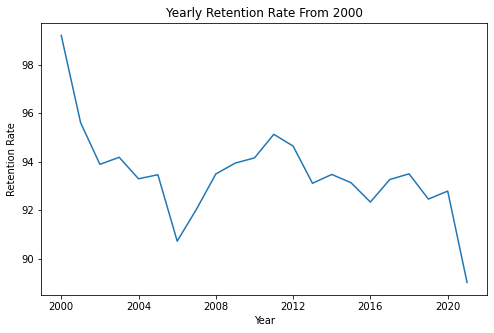

In [22]:
employee_ids = df['emplid_sec'].unique()

start_date = []
end_date = []

#Condense multiple rows of record for each employee into one and create a dataframe (only looking at start and end date)
for ID in employee_ids:
    employee = df[df['emplid_sec'] == ID].copy()
    employee.sort_values(by=['end_date'], inplace=True)
    start_date.append(employee.iloc[0]['start_date'])
    #If the employee is currently working, use the temporary end date
    if(pd.isnull(employee.iloc[-1]['end_date'])):
        end_date.append(temp_end_date)
    else:
        end_date.append(employee.iloc[-1]['end_date'])
    
rr_df = pd.DataFrame({'start_date': start_date,
                      'end_date': end_date})

##################################

rr = []

for year in years:
    #Employees working as of beginning of year
    starting_employees = rr_df[(rr_df['start_date'] <= year) & (rr_df['end_date'] >= year)]
    num_se = starting_employees.shape[0]
    #Employees left at the end of year
    newYear = year + DateOffset(years=1)
    ending_employees = starting_employees[starting_employees['end_date'] >= newYear]
    num_ee = ending_employees.shape[0]
    #Calculate retention rate
    if(num_ee == 0):
        rr.append(100)
    else:
        rr.append(num_ee / num_se * 100)
        
plt.figure(figsize=(8,5))
plt.plot(years, rr)
plt.title('Yearly Retention Rate From 2000')
plt.xlabel('Year')
plt.ylabel('Retention Rate');

The retention rate has been declining since around 2010.

# Duration Analysis

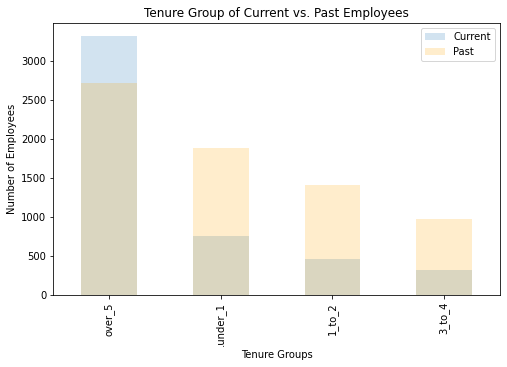

In [23]:
#Plot the frequency of the duration of employement between the two groups
ax = curr_empl_df['tenure_group'].value_counts().plot.bar(alpha=0.2);
past_empl_df['tenure_group'].value_counts().plot.bar(ax=ax, alpha=0.2, color='orange', figsize=(8,5));
plt.title('Tenure Group of Current vs. Past Employees')
plt.xlabel('Tenure Groups')
plt.ylabel('Number of Employees')
plt.legend(['Current', 'Past']);

The majority of both current and past employees worked over 5 years.

In [24]:
#Past employees who worked less than 5 years
past_empl_under_5_df = past_empl_df[past_empl_df['tenure_group'] != 'over_5'].copy()

In [25]:
#This chart will only be intelligible for columns with small amount of unique values
#Compares the value counts between past employees who worked under 5 years and all employees
#The percentage for each bar represents the proportion of past to all employees for each unique value
#  col: column name to analyze (number of unique values in the col must be the same for both dataframes)
def bar_chart_compared_tenure(col):
    print('Proportion of \'Past\' to \'All\': ', str('{:.2f}'.format(round((past_empl_under_5_df.shape[0]/all_empl_df.shape[0])*100, 2)))+'%')
    pvc = past_empl_under_5_df[col].value_counts().sort_index()
    avc = all_empl_df[col].value_counts().sort_index()
    ax = pd.DataFrame({'Past Employees (under 5 years)': pvc.values,
                       'All Employees': avc.values}, index=pvc.index).plot.bar(figsize=(len(pvc)*1.5,5), width = 0.5, stacked=True);
    percentages = [p/a for p,a in zip(pvc.values, avc.values)]
    for i in range(len(pvc)):
        ax.text(ax.patches[i].get_x()+.01, ax.patches[i].get_height(), str('{:.2f}'.format(round(percentages[i]*100, 2)))+'%', fontsize=11)

Proportion of 'Past' to 'All':  36.07%


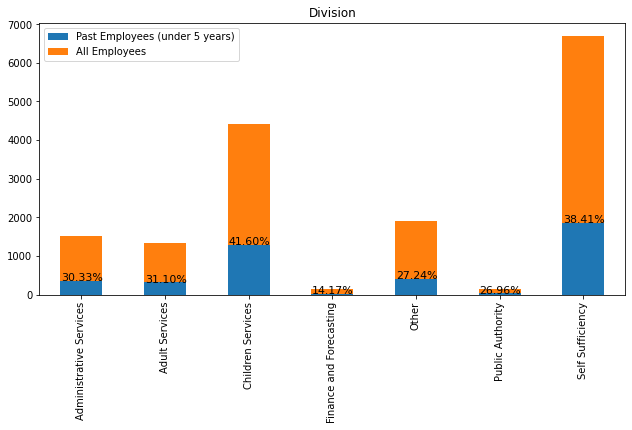

In [26]:
bar_chart_compared_tenure('division')
plt.title('Division');

Childern Services has more past employees who worked less than 5 years than other divisions.

Proportion of 'Past' to 'All':  36.07%


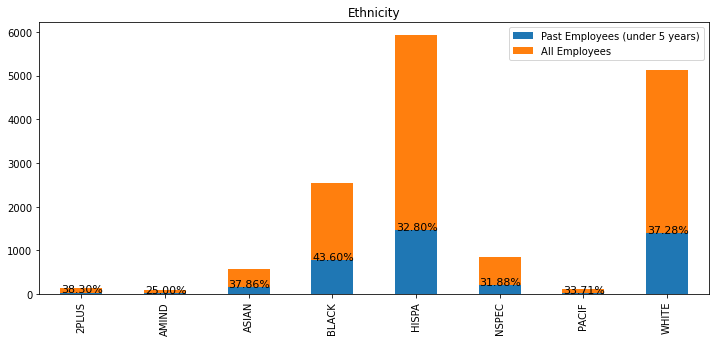

In [27]:
bar_chart_compared_tenure('ethnicity')
plt.title('Ethnicity');

Looking at ethnicity, more past employees who worked less than 5 years were `black`, followed by `asian` and `white`.

Proportion of 'Past' to 'All':  36.07%


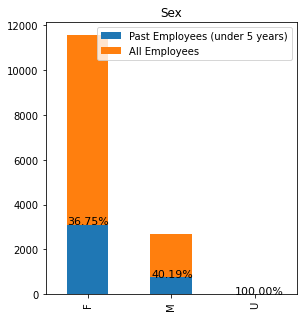

In [28]:
bar_chart_compared_tenure('sex')
plt.title('Sex');

Looking at sex, more past employees who worked less than 5 years were `male`.

Proportion of 'Past' to 'All':  36.07%


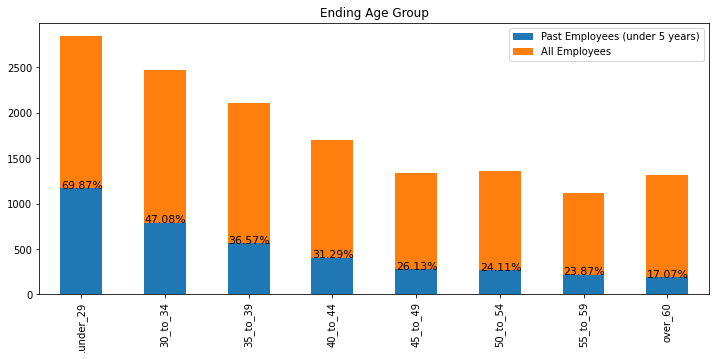

In [29]:
bar_chart_compared_tenure('end_age_group')
plt.title('Ending Age Group');

Looking at the age when the employment is terminated, employees who worked less than 5 years tends to be younger. However, this is misleading because those who worked more than 5 years are moved into higher age group so there tends to be less older employees who worked less than 5 years.

Proportion of 'Past' to 'All':  36.07%


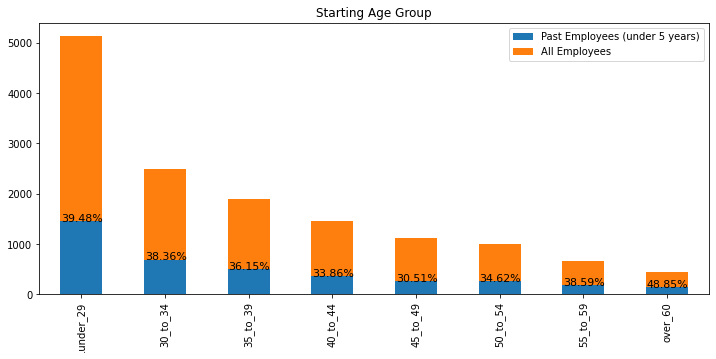

In [30]:
bar_chart_compared_tenure('start_age_group')
plt.title('Starting Age Group');

If we look at the age at when they were hired, we can see less of a corrleation. Although, groups on the opposite ends has a higher percentage compared to the groups in the middle.

Proportion of 'Past' to 'All':  36.07%


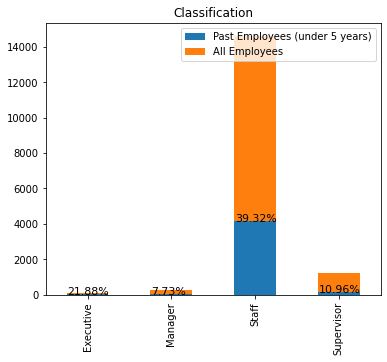

In [31]:
bar_chart_compared_tenure('classification')
plt.title('Classification');

Looking at classification, `Staff` had more employees who worked less than 5 years compared to others.

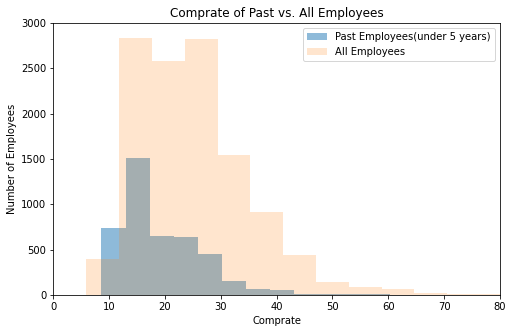

In [32]:
ax = past_empl_under_5_df['comprate'].plot.hist(alpha=0.5, bins=24);
all_empl_df['comprate'].plot.hist(ax=ax, alpha=0.2, figsize=(8,5), bins=24);
plt.title('Comprate of Past vs. All Employees')
plt.xlabel('Comprate')
plt.ylabel('Number of Employees')
plt.axis([0, 80, 0, 3000])
plt.legend(['Past Employees(under 5 years)', 'All Employees']);

Looking at the comprate distribution, the distribution for past employees who worked less than 5 years is similar to the distribution for all employees with a small shift to the left. This suggests past employees who worked less than 5 years tend to have lower comprate. However, we are looking at the last comprate before the end of employement so it would make sense that those who are employed for longer gets more raises.